<>:49: SyntaxWarning: invalid escape sequence '\m'
<>:49: SyntaxWarning: invalid escape sequence '\m'
C:\Users\pantu\AppData\Local\Temp\ipykernel_31132\389793541.py:49: SyntaxWarning: invalid escape sequence '\m'
  dataset_mnist = torchvision.datasets.MNIST("datasets\mnist", download=True, train=True, transform=transforms)


Using device: cuda


  0%|          | 0/1313 [00:00<?, ?it/s]

Epoch [1/3], loss_mean=0.298: 100%|██████████| 1313/1313 [00:08<00:00, 154.41it/s]


loss_mean = 0.298, Q_val = 0.232


Epoch [2/3], loss_mean=0.195: 100%|██████████| 1313/1313 [00:08<00:00, 148.50it/s]


loss_mean = 0.195, Q_val = 0.186


Epoch [3/3], loss_mean=0.166: 100%|██████████| 1313/1313 [00:08<00:00, 158.23it/s]


loss_mean = 0.166, Q_val = 0.205


100%|██████████| 20/20 [00:02<00:00,  7.94it/s]


Test Accuracy: 0.9483


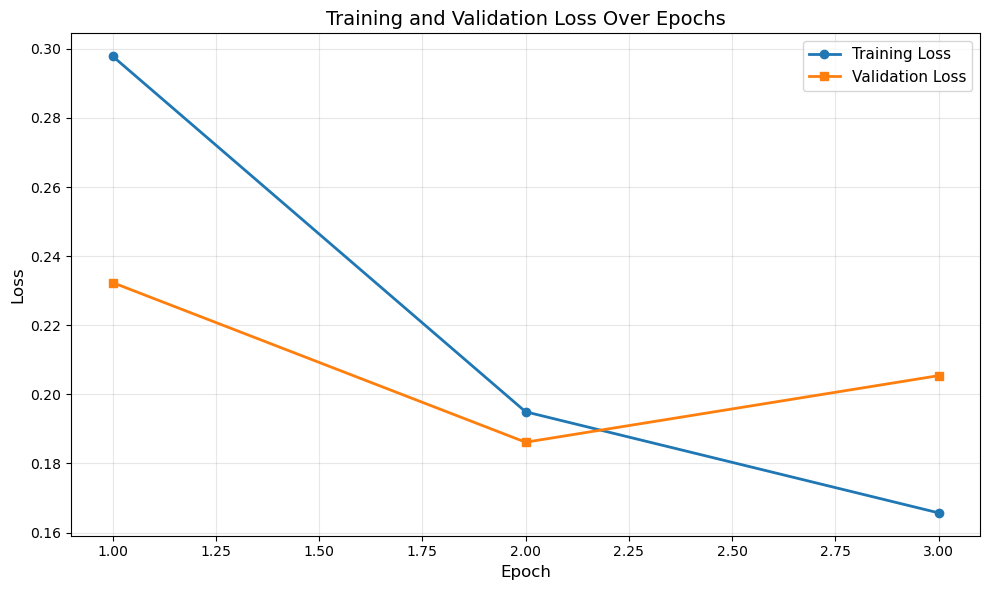


Final Results:
Training Loss: 0.1657
Validation Loss: 0.2054
Test Accuracy: 0.9483


In [ ]:
# MNIST save model p3 (split to train test val)
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
import torch
import torch.utils.data as data
import json
from PIL import Image
import torchvision.transforms.v2 as tfs
import torchvision
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt

# GPU setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


class RavelTransform(nn.Module):
    def forward(self,item):
        return item.ravel()


class DigitNN(nn.Module):
    def __init__(self, input_dim, num_hid, out_dim):
        super().__init__()
        self.layer1 = nn.Linear(input_dim,num_hid)
        self.layer2 = nn.Linear(num_hid, out_dim)

    def forward(self,x):
        x = self.layer1(x)
        x = nn.functional.relu(x)
        x = self.layer2(x)
        return x

model = DigitNN(28 * 28, 32, 10).to(device)  # Move model to GPU


# Setting trnsform
transforms = tfs.Compose([tfs.ToImage(),
                          tfs.Grayscale(), 
                          tfs.ToDtype(torch.float32, scale=True), # converting to float
                          RavelTransform() # or tfs.Lambda(lambda _im: _im.ravel()),
                          ])


dataset_mnist = torchvision.datasets.MNIST("datasets\mnist", download=True, train=True, transform=transforms)
d_train, d_val = data.random_split(dataset_mnist , [0.7, 0.3])
train_data = data.DataLoader(d_train, batch_size=32, shuffle=True)
train_data_val = data.DataLoader(d_val, batch_size=32, shuffle=False)

optimizer = optim.Adam(params=model.parameters(), lr=0.01)
loss_function = nn.CrossEntropyLoss()

# Lists to store metrics for plotting
train_losses = []
val_losses = []

ep = 3
for _e in range(ep):
    model.train()
    loss_mean = 0
    loss_count = 0
    
    train_data_tqdm = tqdm(train_data, leave=True)
    for x_train_img, y_target in train_data_tqdm:
        # Move data to GPU
        x_train_img, y_target = x_train_img.to(device), y_target.to(device)
        
        predict = model(x_train_img)
        loss = loss_function(predict, y_target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_count +=1
        loss_mean = 1/loss_count * loss.item() + (1 - 1/loss_count) * loss_mean
        train_data_tqdm.set_description(f"Epoch [{_e+1}/{ep}], loss_mean={loss_mean:.3f}")

    train_losses.append(loss_mean)

    # Validataion
    model.eval()
    Q_val = 0
    count_val = 0

    with torch.no_grad():  # No gradients needed for validation
        for x_val_img , y_target_val in train_data_val:
            # Move data to GPU
            x_val_img, y_target_val = x_val_img.to(device), y_target_val.to(device)
            
            p = model(x_val_img)
            loss = loss_function(p,y_target_val)
            Q_val+= loss.item()
            count_val +=1
    Q_val /= count_val
    val_losses.append(Q_val)

    print(f"loss_mean = {loss_mean:.3f}, Q_val = {Q_val:.3f}")


# Test
d_test = ImageFolder("datasets/MNIST/test", transform=transforms)
test_data = data.DataLoader(d_test , batch_size=500, shuffle=False)
Q = 0

model.eval()

test_tqdm = tqdm(test_data, leave=True)
with torch.no_grad():  # No gradients needed for testing
    for x_test, y_test in test_tqdm:
        # Move data to GPU
        x_test, y_test = x_test.to(device), y_test.to(device)
        
        p = model(x_test) # 500, 10
        p = torch.argmax(p, dim=1) # 500,1
        Q += torch.sum(p == y_test).item()

Q /= len(d_test)
print(f"Test Accuracy: {Q:.4f}")


# Plot training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(range(1, ep+1), train_losses, marker='o', label='Training Loss', linewidth=2)
plt.plot(range(1, ep+1), val_losses, marker='s', label='Validation Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training and Validation Loss Over Epochs', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('training_validation_loss.png', dpi=150)
plt.show()

print(f"\nFinal Results:")
print(f"Training Loss: {train_losses[-1]:.4f}")
print(f"Validation Loss: {val_losses[-1]:.4f}")
print(f"Test Accuracy: {Q:.4f}")

In [2]:
# 4
import torch
import torch.utils.data as data

class FuncDataset(data.Dataset):
    def __init__(self):
        self.coord_x = torch.arange(-4, 4, 0.01)
        self.coord_y = self.coord_x**2 + 0.5 * self.coord_x - torch.sin(5 * self.coord_x)
        self.length =  len(self.coord_x)

    def __getitem__(self, index):
        return self.coord_x[index], self.coord_y[index], 
    
    def __len__(self):
        return self.length
    

dataset_func = FuncDataset()
d_train, d_val = data.random_split(dataset_func, [0.8, 0.2])

train_data = data.DataLoader(d_train, batch_size=16, shuffle=True)
train_data_val = data.DataLoader(d_val, batch_size=100, shuffle=False)

In [1]:
# 5 
import torch
import torch.utils.data as data


class ClassDataset(data.Dataset):
    def __init__(self):

        _data_x = [(5.3, 2.3), (5.7, 2.5), (4.0, 1.0), (5.6, 2.4), (4.5, 1.5), (5.4, 2.3), (4.8, 1.8), (4.5, 1.5), (5.1, 1.5), (6.1, 2.3), (5.1, 1.9), (4.0, 1.2), (5.2, 2.0), (3.9, 1.4), (4.2, 1.2), (4.7, 1.5), (4.8, 1.8), (3.6, 1.3), (4.6, 1.4), (4.5, 1.7), (3.0, 1.1), (4.3, 1.3), (4.5, 1.3), (5.5, 2.1), (3.5, 1.0), (5.6, 2.2), (4.2, 1.5), (5.8, 1.8), (5.5, 1.8), (5.7, 2.3), (6.4, 2.0), (5.0, 1.7), (6.7, 2.0), (4.0, 1.3), (4.4, 1.4), (4.5, 1.5), (5.6, 2.4), (5.8, 1.6), (4.6, 1.3), (4.1, 1.3), (5.1, 2.3), (5.2, 2.3), (5.6, 1.4), (5.1, 1.8), (4.9, 1.5), (6.7, 2.2), (4.4, 1.3), (3.9, 1.1), (6.3, 1.8), (6.0, 1.8), (4.5, 1.6), (6.6, 2.1), (4.1, 1.3), (4.5, 1.5), (6.1, 2.5), (4.1, 1.0), (4.4, 1.2), (5.4, 2.1), (5.0, 1.5), (5.0, 2.0), (4.9, 1.5), (5.9, 2.1), (4.3, 1.3), (4.0, 1.3), (4.9, 2.0), (4.9, 1.8), (4.0, 1.3), (5.5, 1.8), (3.7, 1.0), (6.9, 2.3), (5.7, 2.1), (5.3, 1.9), (4.4, 1.4), (5.6, 1.8), (3.3, 1.0), (4.8, 1.8), (6.0, 2.5), (5.9, 2.3), (4.9, 1.8), (3.3, 1.0), (3.9, 1.2), (5.6, 2.1), (5.8, 2.2), (3.8, 1.1), (3.5, 1.0), (4.5, 1.5), (5.1, 1.9), (4.7, 1.4), (5.1, 1.6), (5.1, 2.0), (4.8, 1.4), (5.0, 1.9), (5.1, 2.4), (4.6, 1.5), (6.1, 1.9), (4.7, 1.6), (4.7, 1.4), (4.7, 1.2), (4.2, 1.3), (4.2, 1.3)]
        _data_y = [1, 1, -1, 1, -1, 1, 1, -1, 1, 1, 1, -1, 1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, 1, -1, 1, -1, 1, 1, 1, 1, -1, 1, -1, -1, -1, 1, 1, -1, -1, 1, 1, 1, 1, -1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, 1, -1, -1, 1, 1, -1, 1, -1, 1, 1, 1, -1, 1, -1, 1, 1, 1, 1, -1, -1, 1, 1, -1, -1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, -1, -1, -1, -1]

        self.data_x = torch.tensor(_data_x)
        self.data_y = torch.tensor(_data_y)
        self.length =  len(_data_x)

    def __getitem__(self, index):
        return self.data_x[index], self.data_y[index], 
    
    def __len__(self):
        return self.length

dataset_class = ClassDataset()
d_train, d_val, d_test = data.random_split(dataset_class , [0.5, 0.3, 0.2])

train_data = data.DataLoader(d_train , batch_size=32, shuffle=True, drop_last=True)
train_data_val = data.DataLoader(d_val , batch_size=50, shuffle=False)
test_data = data.DataLoader(d_test , batch_size=20, shuffle=False)


In [1]:
# 6
import torch
import torch.utils.data as data
import torch.nn as nn
import torch.optim as optim

class FuncModel(nn.Module):
    def __init__(self):
        super().__init__()
        # модель однослойной полносвязной нейронной сети:
        # 1-й слой: число входов 5 (x, x^2, x^3, x^4, x^5), число нейронов 1
        self.layer = nn.Linear(5, 1)

    def forward(self, x):
        x.unsqueeze_(-1)
        xx = torch.cat([x, x ** 2, x ** 3, x ** 4, x ** 5], dim=1)
        y = self.layer(xx)
        return y


torch.manual_seed(1)

model = FuncModel() # создать модель FuncModel

epochs = 20 # число эпох обучения
batch_size = 16 # размер батча

# данные обучающей выборки (значения функции)
data_x = torch.arange(-5, 5, 0.05) #тензоры data_x, data_y не менять
data_y = torch.sin(2 * data_x) - 0.3 * torch.cos(8 * data_x) + 0.1 * data_x ** 2

ds = data.TensorDataset(data_x, data_y) # создание dataset
d_train, d_val = data.random_split(ds, [0.7, 0.3 ]) # разделить ds на две части в пропорции: 70% на 30%
train_data = data.DataLoader(d_train, batch_size=batch_size, shuffle=True) # создать объект класса DataLoader для d_train с размером пакетов batch_size и перемешиванием образов выборки
train_data_val = data.DataLoader(d_val, batch_size=batch_size, shuffle=False)# создать объект класса DataLoader для d_val с размером пакетов batch_size и без перемешивания образов выборки

optimizer = optim.RMSprop(params=model.parameters(), lr=0.01) # создать оптимизатор RMSprop для обучения модели с шагом обучения 0.01
loss_func = nn.MSELoss() # создать функцию потерь с помощью класса MSELoss

loss_lst_val = []  # список значений потерь при валидации
loss_lst = []  # список значений потерь при обучении

for _e in range(epochs):
    # перевести модель в режим обучения
    model.train()
    loss_mean = 0 # вспомогательные переменные для вычисления среднего значения потерь при обучении
    lm_count = 0

    for x_train, y_train in train_data:
        predict = model(x_train) # вычислить прогноз модели для данных x_train
        loss = loss_func(predict, y_train.unsqueeze(-1)) # вычислить значение функции потерь

        # сделать один шаг градиентного спуска для корректировки параметров модели
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # вычисление среднего значения функции потерь по всей выборке
        lm_count += 1
        loss_mean = 1 / lm_count * loss.item() + (1 - 1 / lm_count) * loss_mean

    # валидация модели
    # перевести модель в режим эксплуатации
    model.eval()
    Q_val = 0
    count_val = 0

    for x_val, y_val in train_data_val:
        with torch.no_grad():
            # для x_val, y_val вычислить потери с помощью функции loss_func
            p = model(x_val)
            loss = loss_func(p, y_val.unsqueeze(-1))
            Q_val+= loss.item()
            count_val +=1

    # сохранить средние потери, вычисленные по выборке валидации, в переменной Q_val
    loss_lst.append(loss_mean)
    loss_lst_val.append(Q_val)

# перевести модель в режим эксплуатации
model.eval()

# выполнить прогноз модели по всем данным выборки (ds.data)
p = model(data_x)
Q = loss_func(p,data_y.unsqueeze(-1)).item() # вычислить потери с помощью loss_func по всем данным выборки ds; значение Q сохранить в виде вещественного числа
# print(f"Test Accuracy: {Q:.4f}")

In [ ]:
# 7 
import torch
import torch.utils.data as data
import torch.nn as nn
import torch.optim as optim


class FuncModel(nn.Module):
    def __init__(self):
        super().__init__()
        # модель однослойной полносвязной нейронной сети:
        # 1-й слой: число входов 4 (x, x^2, x^3, x^4), число нейронов 1
        self.layer = nn.Linear(4,1)

    def forward(self, x):
        # реализация модели нейронной сети
        x.unsqueeze_(-1)
        xx = torch.cat([x, x ** 2, x ** 3, x ** 4], dim=1)
        y = self.layer(xx)
        return y


torch.manual_seed(1)

model = FuncModel() # создать модель FuncModel

epochs = 15 # число эпох обучения
batch_size = 32 # размер батча

# создание обучающей выборки (значения функции)
data_x = torch.arange(-3, 3, 0.01) #тензоры data_x, data_y не менять
data_y = 0.2 * data_x ** 3 + 0.5 * torch.sin(5 * data_x) - 0.1 * data_x ** 2

ds = data.TensorDataset(data_x, data_y) # создание dataset
d_train, d_val = data.random_split(ds, [0.8, 0.2]) # разделить ds на две части в пропорции: 80% на 20%
train_data = data.DataLoader(d_train, batch_size,shuffle=True ) # создать объект класса DataLoader для d_train с размером пакетов batch_size и перемешиванием образов выборки
train_data_val = data.DataLoader(d_val, batch_size,shuffle=False ) # создать объект класса DataLoader для d_val с размером пакетов batch_size и без перемешивания образов выборки

optimizer = optim.Adam(params=model.parameters(), lr = 0.01 ) # создать оптимизатор Adam для обучения модели с шагом обучения 0.01
loss_func = nn.MSELoss() # создать функцию потерь с помощью класса MSELoss

loss_lst_val = []  # список значений потерь при валидации
loss_lst = []  # список значений потерь при обучении

for _e in range(epochs):
    loss_mean = 0 # вспомогательные переменные для вычисления среднего значения потерь при обучении
    lm_count = 0

    # обучение нейронной сети с вычисление средних потерь loss_mean
    model.train()
    for x_train, y_train in train_data:
        predict = model(x_train)
        loss  = loss_func(predict , y_train.unsqueeze(-1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        lm_count+=1
        loss_mean = 1 / lm_count* loss.item() + (1 - 1/ lm_count) * loss_mean

    # валидация нейронной сети с вычислением средних потерь Q_val
    model.eval()
    Q_val = 0
    count_val = 0

    for x_val , y_val in train_data_val:
        p = model(x_val)
        loss = loss_func(p , y_val.unsqueeze(-1))
        Q_val += loss.item()
        count_val +=1

    Q_val /= count_val

    # добавление в списки вычисленных значений потерь
    loss_lst.append(loss_mean)
    loss_lst_val.append(Q_val)

# перевести модель в режим эксплуатации
model.eval()
# выполнить прогноз модели по всем данным выборки (ds.data)
pred = model(data_x)
# вычислить потери с помощью loss_func по всем данным выборки ds; значение Q сохранить в виде вещественного числа
Q = loss_func(pred , data_y.unsqueeze(-1)).item()